In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/DAB 공모전/데이터셋')
car_df=pd.read_excel('car_data.xlsx')
people_df=pd.read_excel('people_data.xlsx')
anam=pd.read_excel('anam_data.xlsx')

In [ ]:
people_df = people_df.drop(people_df[(people_df['serial'] == 'd02544fffef125e8') & (people_df['date'] == '2020-07-01')].index, axis=0)

d02544fffef125e8 = people_df[people_df['serial'] == 'd02544fffef125e8']
d02544fffef125e8 = d02544fffef125e8.reset_index(drop=True)

pole_78 = car_df[(car_df['pole_num'] == 7) | (car_df['pole_num'] == 8)]
pole_78 = pole_78.reset_index(drop=True)

car_78 = pole_78.groupby('time')['road_car'].sum()

# 안암역 데이터 반영

In [ ]:
anam

,people,car
hour,,
8,552,NaN
9,280,NaN
10,450,NaN
11,1176,NaN
18,966,242.0
19,606,152.0
20,462,116.0


In [ ]:
anam = anam.reset_index()

# 'hour' 열을 새로운 인덱스로 설정
anam = anam.set_index('hour')
anam=anam.drop('index',axis=1)


In [ ]:
#가짜 데이터
anam.loc[8, 'car'] = 1520
anam.loc[9, 'car'] = 1160
anam.loc[10, 'car'] = 1430
anam.loc[11, 'car'] = 4000

anam

,people,car
hour,,
8,552,1520.0
9,280,1160.0
10,450,1430.0
11,1176,4000.0
18,966,242.0
19,606,152.0
20,462,116.0


In [ ]:
def calculate_PLC(x, y, B, y_min, x_min):
    P = (x_min + y) ** 2 / (2 * (x + y))
    l = B**2*x*y_min / (1 - B*y_min)
    C = (B*x**2 - (B*x*(B*x*-1) / (2*B)) + y_min * B*x*(B*x-1) / 2 + (B*x*l + l*(l-1)/2 - l*(l-1)/(2*B*y_min))*y_min) / (B*(x+y))
    return P, l, C

hours = []
mean_waits = []
origin_waits = []
car_greens_0 = []

for hour in anam.index:
    B = anam['car'].loc[hour]
    A = anam['people'].loc[hour]

    x_min = 20 / 3600 # 보행자가 지나는데 필요한 최소시간
    y_min = 7 / 3600 # 차량이 1대 지나는 시간
    x_max = 100 / 3600
    y_max = 300 / 3600

    x = 0
    y = 0 # y < B * x / y_min

    optimal_min = 2e9

    for i in range(20, 100):
      x = i / 3600
      for j in range(7, 300):
        y = j / 3600

        if y <= B*x*y_min: continue
        P, L, C = calculate_PLC(x, y, B, y_min, x_min)
        mean = (P * A + C * B) / (A+B)
        if mean < optimal_min:
          optimal_min = mean
          people_green = i
          car_green = j
          people_wait = P
          car_wait = C

    #기존 점멸주기
    x2 = 40 / 3600
    y2 = 100 / 3600

    P = (x_min + y2) ** 2 / (2 * (x2 + y2))
    l = B**2*x2*y_min / (1 - B*y_min)
    C = (B*x2**2 - (B*x2*(B*x2*-1) / (2*B)) + y_min * B*x2*(B*x2-1) / 2 + (B*x2*l + l*(l-1)/2 - l*(l-1)/(2*B*y_min))*y_min) / (B*(x2+y2))

    origin_wait = (P * A + C * B) / (A+B)

    print(f"Hour: {hour}, People: {A}, Car: {B}, People green: {people_green}s, Car green: {car_green}s, People wait: {people_wait * 60 * 60:.2f}s, Car wait: {car_wait * 60 * 60:.2f}s, Mean wait: {optimal_min * 60 * 60:.2f}s, Origin wait: {origin_wait  * 60 * 60:.2f}s")
    car_greens_0.append(car_green)

Hour: 8, People: 552, Car: 1520.0, People green: 20s, Car green: 60s, People wait: 40.00s, Car wait: 3.72s, Mean wait: 13.39s, Origin wait: 19.94s
Hour: 9, People: 280, Car: 1160.0, People green: 20s, Car green: 46s, People wait: 33.00s, Car wait: 3.65s, Mean wait: 9.35s, Origin wait: 15.54s
Hour: 10, People: 450, Car: 1430.0, People green: 20s, Car green: 56s, People wait: 38.00s, Car wait: 3.79s, Mean wait: 11.97s, Origin wait: 18.56s
Hour: 11, People: 1176, Car: 4000.0, People green: 20s, Car green: 156s, People wait: 88.00s, Car wait: 2.11s, Mean wait: 21.62s, Origin wait: 19.87s
Hour: 18, People: 966, Car: 242.0, People green: 21s, Car green: 10s, People wait: 14.52s, Car wait: 27.66s, Mean wait: 17.15s, Origin wait: 45.58s
Hour: 19, People: 606, Car: 152.0, People green: 23s, Car green: 7s, People wait: 12.15s, Car wait: 30.15s, Mean wait: 15.76s, Origin wait: 45.03s
Hour: 20, People: 462, Car: 116.0, People green: 24s, Car green: 7s, People wait: 11.76s, Car wait: 30.58s, Mean w

In [ ]:
car_greens_0.sort()
print(car_greens_0)
100 - np.median(car_greens_0)

[7, 7, 10, 46, 56, 60, 156]


54.0

Hour: 8, People: 552, Car: 1520.0, People green: 20s, Car green: 114s, People wait: 67.00s, Car wait: 2.22s, Mean wait: 19.48s, Origin wait: 19.94s
Hour: 9, People: 280, Car: 1160.0, People green: 20s, Car green: 100s, People wait: 60.00s, Car wait: 2.01s, Mean wait: 13.28s, Origin wait: 15.54s
Hour: 10, People: 450, Car: 1430.0, People green: 20s, Car green: 110s, People wait: 65.00s, Car wait: 2.21s, Mean wait: 17.24s, Origin wait: 18.56s
Hour: 11, People: 1176, Car: 4000.0, People green: 20s, Car green: 210s, People wait: 115.00s, Car wait: 1.61s, Mean wait: 27.37s, Origin wait: 19.87s
Hour: 18, People: 966, Car: 242.0, People green: 21s, Car green: 64s, People wait: 41.51s, Car wait: 10.09s, Mean wait: 35.21s, Origin wait: 45.58s
Hour: 19, People: 606, Car: 152.0, People green: 23s, Car green: 61s, People wait: 39.05s, Car wait: 10.77s, Mean wait: 33.38s, Origin wait: 45.03s
Hour: 20, People: 462, Car: 116.0, People green: 24s, Car green: 61s, People wait: 38.59s, Car wait: 11.15s,

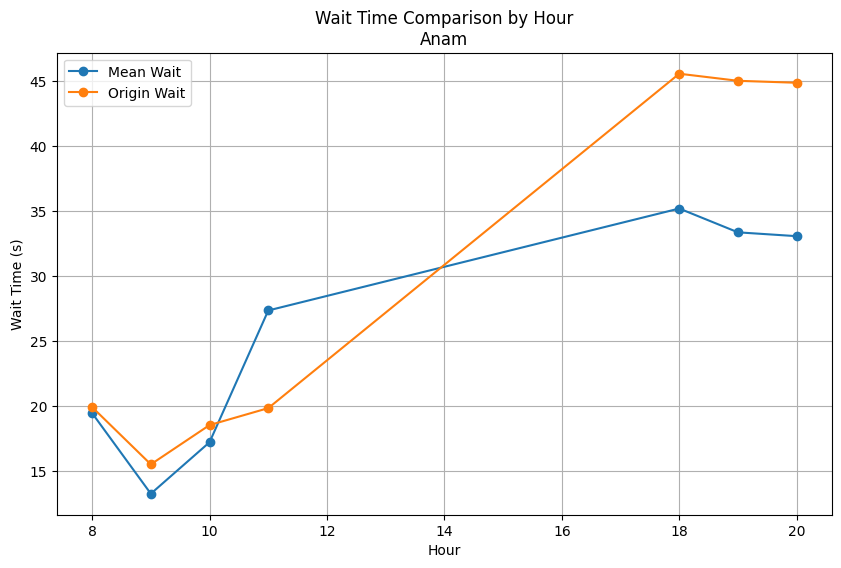

In [ ]:
hours = []
mean_waits = []
origin_waits = []

for hour in anam.index:
    B = anam['car'].loc[hour]
    A = anam['people'].loc[hour]

    x_min = 20 / 3600 # 보행자가 지나는데 필요한 최소시간
    y_min = 7 / 3600 # 차량이 1대 지나는 시간
    x_max = 100 / 3600
    y_max = 300 / 3600

    x = 0
    y = 0 # y < B * x / y_min

    optimal_min = 2e9

    for i in range(20, 100):
      x = i / 3600
      for j in range(7, 300):
        y = j / 3600

        if y <= B*x*y_min: continue
        # 보행자 대기시간 기댓값
        P = (x_min + y) ** 2 / (2 * (x + y))

        # 차량 대기시간 기댓값
        l = B**2*x*y_min / (1 - B*y_min)
        C = (B*x**2 - (B*x*(B*x*-1) / (2*B)) + y_min * B*x*(B*x-1) / 2 + (B*x*l + l*(l-1)/2 - l*(l-1)/(2*B*y_min))*y_min) / (B*(x+y))

        mean = (P * A + C * B) / (A+B)
        if mean < optimal_min:
          optimal_min = mean
          people_green = i
          car_green = j
          people_wait = P
          car_wait = C

    # 89초 더해서 다시 계산.
    car_green += 54
    x = people_green / 3600
    y = (car_green) / 3600
    P = (x_min + y) ** 2 / (2 * (x + y))

    # 차량 대기시간 기댓값
    l = B**2*x*y_min / (1 - B*y_min)
    C = (B*x**2 - (B*x*(B*x*-1) / (2*B)) + y_min * B*x*(B*x-1) / 2 + (B*x*l + l*(l-1)/2 - l*(l-1)/(2*B*y_min))*y_min) / (B*(x+y))

    people_wait = P
    car_wait = C
    optimal_min = (P * A + C * B) / (A+B)

    #기존 점멸주기
    x2 = 40 / 3600
    y2 = 100 / 3600

    P = (x_min + y2) ** 2 / (2 * (x2 + y2))
    l = B**2*x2*y_min / (1 - B*y_min)
    C = (B*x2**2 - (B*x2*(B*x2*-1) / (2*B)) + y_min * B*x2*(B*x2-1) / 2 + (B*x2*l + l*(l-1)/2 - l*(l-1)/(2*B*y_min))*y_min) / (B*(x2+y2))

    origin_wait = (P * A + C * B) / (A+B)

    print(f"Hour: {hour}, People: {A}, Car: {B}, People green: {people_green}s, Car green: {car_green}s, People wait: {people_wait * 60 * 60:.2f}s, Car wait: {car_wait * 60 * 60:.2f}s, Mean wait: {optimal_min * 60 * 60:.2f}s, Origin wait: {origin_wait  * 60 * 60:.2f}s")

    # 시간대별 데이터 저장
    hours.append(hour)
    mean_waits.append(optimal_min * 60 * 60)
    origin_waits.append(origin_wait * 60 * 60)

plt.figure(figsize=(10,6))
plt.plot(hours, mean_waits, label='Mean Wait', marker='o')
plt.plot(hours, origin_waits, label='Origin Wait', marker='o')
plt.xlabel('Hour')
plt.ylabel('Wait Time (s)')
plt.title('Wait Time Comparison by Hour\nAnam')
plt.legend()
plt.grid(True)
plt.show()

# 스마트폴 7-8번 최종 코드

In [ ]:
d02544fffef125e8['date'].unique()

array(['2021-04-26', '2022-10-01'], dtype=object)

# 2021년 4월


In [ ]:
def calculate_PLC(x, y, B, y_min, x_min):
    P = (x_min + y) ** 2 / (2 * (x + y))
    l = B**2*x*y_min / (1 - B*y_min)
    C = (B*x**2 - (B*x*(B*x*-1) / (2*B)) + y_min * B*x*(B*x-1) / 2 + (B*x*l + l*(l-1)/2 - l*(l-1)/(2*B*y_min))*y_min) / (B*(x+y))
    return P, l, C

#pole num 43-44에 대해, 2021년 3월 보행자 데이터 조합
hours = []
mean_waits = []
origin_waits = []
car_greens_1 = []

for hour in range(24):
    B = car_78.loc[hour]
    A = d02544fffef125e8['daily_people'].loc[hour]

    x_min = 36 / 3600 # 보행자가 지나는데 필요한 최소시간
    y_min = 7 / 3600 # 차량이 1대 지나는 시간
    x_max = 100 / 3600
    y_max = 300 / 3600

    x = 0
    y = 0 # y < B * x / y_min

    optimal_min = 2e9

    for i in range(36, 100):
      x = i / 3600
      for j in range(7, 300):
        y = j / 3600

        if y <= B*x*y_min: continue
        P, L, C = calculate_PLC(x, y, B, y_min, x_min)
        mean = (P * A + C * B) / (A+B)
        if mean < optimal_min:
          optimal_min = mean
          people_green = i
          car_green = j
          people_wait = P
          car_wait = C

    #기존 점멸주기
    x2 = 40 / 3600
    y2 = 140 / 3600

    P = (x_min + y2) ** 2 / (2 * (x2 + y2))
    l = B**2*x2*y_min / (1 - B*y_min)
    C = (B*x2**2 - (B*x2*(B*x2*-1) / (2*B)) + y_min * B*x2*(B*x2-1) / 2 + (B*x2*l + l*(l-1)/2 - l*(l-1)/(2*B*y_min))*y_min) / (B*(x2+y2))

    origin_wait = (P * A + C * B) / (A+B)

    print(f"Hour: {hour}, People: {A}, Car: {B}, People green: {people_green}s, Car green: {car_green}s, People wait: {people_wait * 60 * 60:.2f}s, Car wait: {car_wait * 60 * 60:.2f}s, Mean wait: {optimal_min * 60 * 60:.2f}s, Origin wait: {origin_wait  * 60 * 60:.2f}s")
    car_greens_1.append(car_green)

Hour: 0, People: 17, Car: 45, People green: 36s, Car green: 67s, People wait: 51.50s, Car wait: 19.48s, Mean wait: 28.26s, Origin wait: 33.58s
Hour: 1, People: 8, Car: 29, People green: 36s, Car green: 84s, People wait: 60.00s, Car wait: 16.52s, Mean wait: 25.92s, Origin wait: 29.26s
Hour: 2, People: 5, Car: 20, People green: 36s, Car green: 90s, People wait: 63.00s, Car wait: 15.64s, Mean wait: 25.11s, Origin wait: 28.02s
Hour: 3, People: 5, Car: 15, People green: 36s, Car green: 73s, People wait: 54.50s, Car wait: 18.01s, Mean wait: 27.14s, Origin wait: 31.61s
Hour: 4, People: 6, Car: 18, People green: 36s, Car green: 73s, People wait: 54.50s, Car wait: 18.05s, Mean wait: 27.16s, Origin wait: 31.63s
Hour: 5, People: 21, Car: 59, People green: 36s, Car green: 71s, People wait: 53.50s, Car wait: 18.95s, Mean wait: 28.02s, Origin wait: 32.84s
Hour: 6, People: 37, Car: 128, People green: 36s, Car green: 86s, People wait: 61.00s, Car wait: 17.69s, Mean wait: 27.41s, Origin wait: 30.78s
Ho

In [ ]:
car_greens_1.sort()
print(car_greens_1)
100 - np.median(car_greens_1)

[33, 33, 34, 47, 57, 59, 59, 59, 62, 64, 67, 69, 70, 70, 71, 73, 73, 74, 75, 83, 84, 84, 86, 90]


30.5

Hour: 0, People: 17, Car: 45, People green: 36s, Car green: 97s, People wait: 66.50s, Car wait: 15.08s, Mean wait: 29.18s, Origin wait: 33.58s
Hour: 1, People: 8, Car: 29, People green: 36s, Car green: 114s, People wait: 75.00s, Car wait: 13.22s, Mean wait: 26.58s, Origin wait: 29.26s
Hour: 2, People: 5, Car: 20, People green: 36s, Car green: 120s, People wait: 78.00s, Car wait: 12.63s, Mean wait: 25.70s, Origin wait: 28.02s
Hour: 3, People: 5, Car: 15, People green: 36s, Car green: 103s, People wait: 69.50s, Car wait: 14.13s, Mean wait: 27.97s, Origin wait: 31.61s
Hour: 4, People: 6, Car: 18, People green: 36s, Car green: 103s, People wait: 69.50s, Car wait: 14.15s, Mean wait: 27.99s, Origin wait: 31.63s
Hour: 5, People: 21, Car: 59, People green: 36s, Car green: 101s, People wait: 68.50s, Car wait: 14.80s, Mean wait: 28.90s, Origin wait: 32.84s
Hour: 6, People: 37, Car: 128, People green: 36s, Car green: 116s, People wait: 76.00s, Car wait: 14.20s, Mean wait: 28.06s, Origin wait: 30.

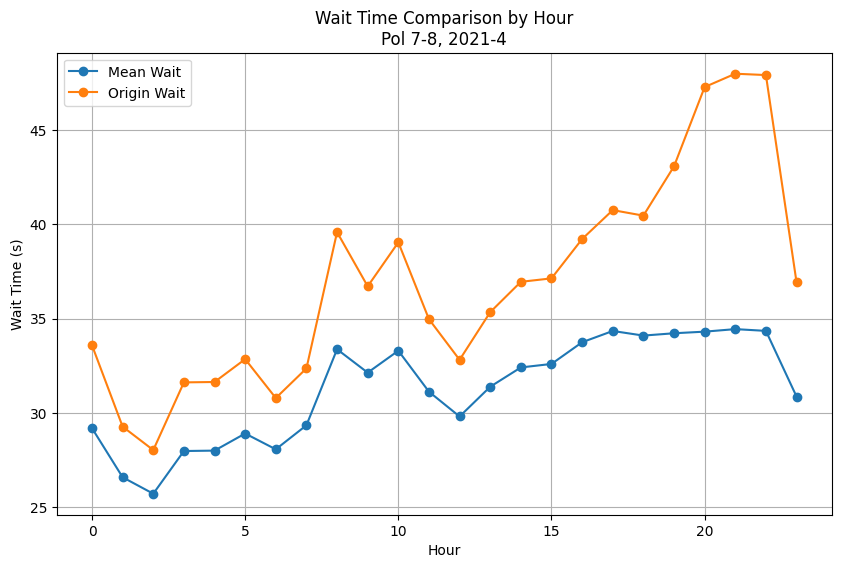

In [ ]:
hours = []
mean_waits = []
origin_waits = []

for hour in range(24):
    B = car_78.loc[hour]
    A = d02544fffef125e8['daily_people'].loc[hour]

    x_min = 36 / 3600 # 보행자가 지나는데 필요한 최소시간
    y_min = 7 / 3600 # 차량이 1대 지나는 시간
    x_max = 100 / 3600
    y_max = 300 / 3600

    x = 0
    y = 0 # y < B * x / y_min

    optimal_min = 2e9

    for i in range(36, 100):
      x = i / 3600
      for j in range(7, 300):
        y = j / 3600

        if y <= B*x*y_min: continue
        # 보행자 대기시간 기댓값
        P = (x_min + y) ** 2 / (2 * (x + y))

        # 차량 대기시간 기댓값
        l = B**2*x*y_min / (1 - B*y_min)
        C = (B*x**2 - (B*x*(B*x*-1) / (2*B)) + y_min * B*x*(B*x-1) / 2 + (B*x*l + l*(l-1)/2 - l*(l-1)/(2*B*y_min))*y_min) / (B*(x+y))

        mean = (P * A + C * B) / (A+B)
        if mean < optimal_min:
          optimal_min = mean
          people_green = i
          car_green = j
          people_wait = P
          car_wait = C

    # 30초 더해서 다시 계산.
    car_green += 30
    x = people_green / 3600
    y = (car_green) / 3600
    P = (x_min + y) ** 2 / (2 * (x + y))

    # 차량 대기시간 기댓값
    l = B**2*x*y_min / (1 - B*y_min)
    C = (B*x**2 - (B*x*(B*x*-1) / (2*B)) + y_min * B*x*(B*x-1) / 2 + (B*x*l + l*(l-1)/2 - l*(l-1)/(2*B*y_min))*y_min) / (B*(x+y))

    people_wait = P
    car_wait = C
    optimal_min = (P * A + C * B) / (A+B)

    #기존 점멸주기
    x2 = 40 / 3600
    y2 = 140 / 3600

    P = (x_min + y2) ** 2 / (2 * (x2 + y2))
    l = B**2*x2*y_min / (1 - B*y_min)
    C = (B*x2**2 - (B*x2*(B*x2*-1) / (2*B)) + y_min * B*x2*(B*x2-1) / 2 + (B*x2*l + l*(l-1)/2 - l*(l-1)/(2*B*y_min))*y_min) / (B*(x2+y2))

    origin_wait = (P * A + C * B) / (A+B)

    print(f"Hour: {hour}, People: {A}, Car: {B}, People green: {people_green}s, Car green: {car_green}s, People wait: {people_wait * 60 * 60:.2f}s, Car wait: {car_wait * 60 * 60:.2f}s, Mean wait: {optimal_min * 60 * 60:.2f}s, Origin wait: {origin_wait  * 60 * 60:.2f}s")

    # 시간대별 데이터 저장
    hours.append(hour)
    mean_waits.append(optimal_min * 60 * 60)
    origin_waits.append(origin_wait * 60 * 60)

plt.figure(figsize=(10,6))
plt.plot(hours, mean_waits, label='Mean Wait', marker='o')
plt.plot(hours, origin_waits, label='Origin Wait', marker='o')
plt.xlabel('Hour')
plt.ylabel('Wait Time (s)')
plt.title('Wait Time Comparison by Hour\nPol 7-8, 2021-4')
plt.legend()
plt.grid(True)
plt.show()

Hour: 0, People: 17, Car: 45, People green: 36s, Car green: 67s, People wait: 51.500s, Car wait: 19.477s, Mean wait: 28.258s, Origin wait: 33.580s
Hour: 1, People: 8, Car: 29, People green: 36s, Car green: 84s, People wait: 60.000s, Car wait: 16.523s, Mean wait: 25.923s, Origin wait: 29.263s
Hour: 2, People: 5, Car: 20, People green: 36s, Car green: 90s, People wait: 63.000s, Car wait: 15.637s, Mean wait: 25.109s, Origin wait: 28.019s
Hour: 3, People: 5, Car: 15, People green: 36s, Car green: 73s, People wait: 54.500s, Car wait: 18.013s, Mean wait: 27.135s, Origin wait: 31.611s
Hour: 4, People: 6, Car: 18, People green: 36s, Car green: 73s, People wait: 54.500s, Car wait: 18.050s, Mean wait: 27.163s, Origin wait: 31.632s
Hour: 5, People: 21, Car: 59, People green: 36s, Car green: 71s, People wait: 53.500s, Car wait: 18.953s, Mean wait: 28.022s, Origin wait: 32.845s
Hour: 6, People: 37, Car: 128, People green: 36s, Car green: 86s, People wait: 61.000s, Car wait: 17.694s, Mean wait: 27.4

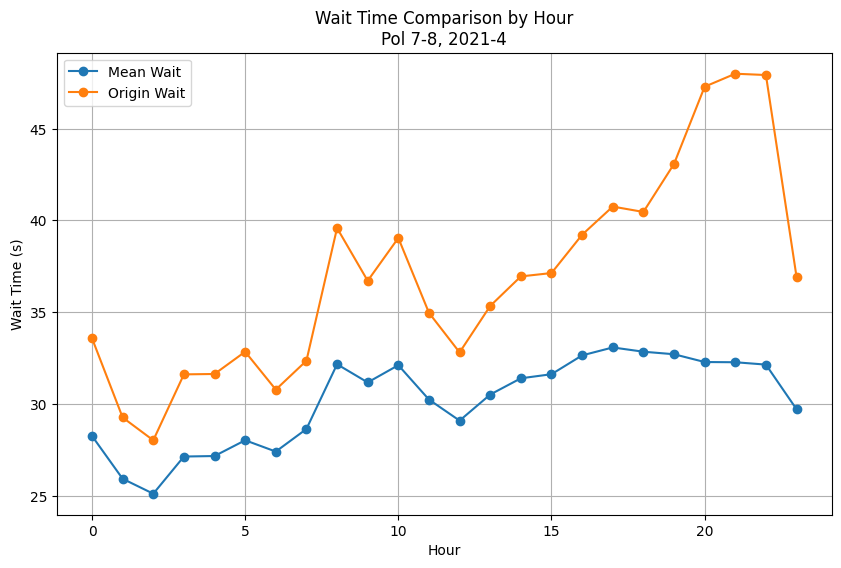

In [ ]:
#pole num 7-8에 대해, 2021년 4월 보행자 데이터 조합
#시각화 추가
hours = []
mean_waits = []
origin_waits = []

for hour in range(24):
    B = car_78.loc[hour]
    A = d02544fffef125e8['daily_people'].loc[hour]

    x_min = 36 / 3600 # 보행자가 지나는데 필요한 최소시간
    y_min = 7 / 3600 # 차량이 1대 지나는 시간
    x_max = 100 / 3600
    y_max = 300 / 3600

    x = 0
    y = 0 # y < B * x / y_min

    optimal_min = 2e9

    for i in range(36, 100):
      x = i / 3600
      for j in range(7, 300):
        y = j / 3600

        if y <= B*x*y_min: continue
        # 보행자 대기시간 기댓값
        P = (x_min + y) ** 2 / (2 * (x + y))

        # 차량 대기시간 기댓값
        l = B**2*x*y_min / (1 - B*y_min)
        C = (B*x**2 - (B*x*(B*x*-1) / (2*B)) + y_min * B*x*(B*x-1) / 2 + (B*x*l + l*(l-1)/2 - l*(l-1)/(2*B*y_min))*y_min) / (B*(x+y))

        mean = (P * A + C * B) / (A+B)
        if mean < optimal_min:
          optimal_min = mean
          people_green = i
          car_green = j
          people_wait = P
          car_wait = C


    #기존 점멸주기
    x2 = 40 / 3600
    y2 = 140 / 3600

    P = (x_min + y2) ** 2 / (2 * (x2 + y2))
    l = B**2*x2*y_min / (1 - B*y_min)
    C = (B*x2**2 - (B*x2*(B*x2*-1) / (2*B)) + y_min * B*x2*(B*x2-1) / 2 + (B*x2*l + l*(l-1)/2 - l*(l-1)/(2*B*y_min))*y_min) / (B*(x2+y2))

    origin_wait = (P * A + C * B) / (A+B)
    #origin_people_wait = P
    #origin_car_wait = C

    print(f"Hour: {hour}, People: {A}, Car: {B}, People green: {people_green}s, Car green: {car_green}s, People wait: {people_wait * 60 * 60:.3f}s, Car wait: {car_wait * 60 * 60:.3f}s, Mean wait: {optimal_min * 60 * 60:.3f}s, Origin wait: {origin_wait  * 60 * 60:.3f}s")

    # 시간대별 데이터 저장
    hours.append(hour)
    mean_waits.append(optimal_min * 60 * 60)
    origin_waits.append(origin_wait * 60 * 60)

plt.figure(figsize=(10,6))
plt.plot(hours, mean_waits, label='Mean Wait', marker='o')
plt.plot(hours, origin_waits, label='Origin Wait', marker='o')
plt.xlabel('Hour')
plt.ylabel('Wait Time (s)')
plt.title('Wait Time Comparison by Hour\nPol 7-8, 2021-4')
plt.legend()
plt.grid(True)
plt.show()

# 2021년 10월

In [ ]:
def calculate_PLC(x, y, B, y_min, x_min):
    P = (x_min + y) ** 2 / (2 * (x + y))
    l = B**2*x*y_min / (1 - B*y_min)
    C = (B*x**2 - (B*x*(B*x*-1) / (2*B)) + y_min * B*x*(B*x-1) / 2 + (B*x*l + l*(l-1)/2 - l*(l-1)/(2*B*y_min))*y_min) / (B*(x+y))
    return P, l, C

#pole num 43-44에 대해, 2021년 10월 보행자 데이터 조합
hours = []
mean_waits = []
origin_waits = []
car_greens_2 = []

for hour in range(24):
    B = car_78.loc[hour]
    A = d02544fffef125e8['daily_people'].loc[24+hour]

    x_min = 36 / 3600 # 보행자가 지나는데 필요한 최소시간
    y_min = 7 / 3600 # 차량이 1대 지나는 시간
    x_max = 100 / 3600
    y_max = 300 / 3600

    x = 0
    y = 0 # y < B * x / y_min

    optimal_min = 2e9

    for i in range(36, 100):
      x = i / 3600
      for j in range(7, 300):
        y = j / 3600

        if y <= B*x*y_min: continue
        P, L, C = calculate_PLC(x, y, B, y_min, x_min)
        mean = (P * A + C * B) / (A+B)
        if mean < optimal_min:
          optimal_min = mean
          people_green = i
          car_green = j
          people_wait = P
          car_wait = C

    #기존 점멸주기
    x2 = 40 / 3600
    y2 = 140 / 3600

    P = (x_min + y2) ** 2 / (2 * (x2 + y2))
    l = B**2*x2*y_min / (1 - B*y_min)
    C = (B*x2**2 - (B*x2*(B*x2*-1) / (2*B)) + y_min * B*x2*(B*x2-1) / 2 + (B*x2*l + l*(l-1)/2 - l*(l-1)/(2*B*y_min))*y_min) / (B*(x2+y2))

    origin_wait = (P * A + C * B) / (A+B)

    print(f"Hour: {hour}, People: {A}, Car: {B}, People green: {people_green}s, Car green: {car_green}s, People wait: {people_wait * 60 * 60:.2f}s, Car wait: {car_wait * 60 * 60:.2f}s, Mean wait: {optimal_min * 60 * 60:.2f}s, Origin wait: {origin_wait  * 60 * 60:.2f}s")
    car_greens_2.append(car_green)

Hour: 0, People: 17, Car: 45, People green: 36s, Car green: 67s, People wait: 51.50s, Car wait: 19.48s, Mean wait: 28.26s, Origin wait: 33.58s
Hour: 1, People: 9, Car: 29, People green: 36s, Car green: 77s, People wait: 56.50s, Car wait: 17.55s, Mean wait: 26.77s, Origin wait: 30.76s
Hour: 2, People: 7, Car: 20, People green: 36s, Car green: 70s, People wait: 53.00s, Car wait: 18.59s, Mean wait: 27.51s, Origin wait: 32.32s
Hour: 3, People: 4, Car: 15, People green: 36s, Car green: 85s, People wait: 60.50s, Car wait: 16.23s, Mean wait: 25.55s, Origin wait: 28.75s
Hour: 4, People: 6, Car: 18, People green: 36s, Car green: 73s, People wait: 54.50s, Car wait: 18.05s, Mean wait: 27.16s, Origin wait: 31.63s
Hour: 5, People: 15, Car: 59, People green: 36s, Car green: 90s, People wait: 63.00s, Car wait: 16.10s, Mean wait: 25.60s, Origin wait: 28.53s
Hour: 6, People: 28, Car: 128, People green: 36s, Car green: 104s, People wait: 70.00s, Car wait: 15.42s, Mean wait: 25.22s, Origin wait: 27.59s
H

In [ ]:
car_greens_2.sort()
print(car_greens_2)
100 - np.median(car_greens_2)

[36, 37, 42, 51, 53, 57, 66, 67, 70, 70, 71, 73, 73, 77, 77, 80, 81, 82, 83, 84, 85, 85, 90, 104]


27.0

Hour: 0, People: 17, Car: 45, People green: 36s, Car green: 94s, People wait: 65.00s, Car wait: 15.43s, Mean wait: 29.02s, Origin wait: 33.58s
Hour: 1, People: 9, Car: 29, People green: 36s, Car green: 104s, People wait: 70.00s, Car wait: 14.16s, Mean wait: 27.39s, Origin wait: 30.76s
Hour: 2, People: 7, Car: 20, People green: 36s, Car green: 97s, People wait: 66.50s, Car wait: 14.81s, Mean wait: 28.21s, Origin wait: 32.32s
Hour: 3, People: 4, Car: 15, People green: 36s, Car green: 112s, People wait: 74.00s, Car wait: 13.27s, Mean wait: 26.05s, Origin wait: 28.75s
Hour: 4, People: 6, Car: 18, People green: 36s, Car green: 100s, People wait: 68.00s, Car wait: 14.47s, Mean wait: 27.85s, Origin wait: 31.63s
Hour: 5, People: 15, Car: 59, People green: 36s, Car green: 117s, People wait: 76.50s, Car wait: 13.25s, Mean wait: 26.07s, Origin wait: 28.53s
Hour: 6, People: 28, Car: 128, People green: 36s, Car green: 131s, People wait: 83.50s, Car wait: 12.93s, Mean wait: 25.59s, Origin wait: 27.5

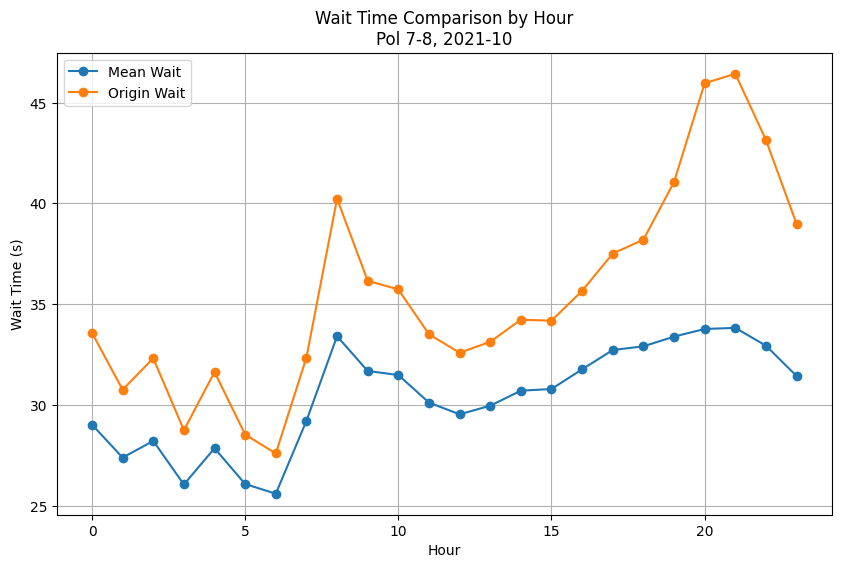

In [ ]:
hours = []
mean_waits = []
origin_waits = []

for hour in range(24):
    B = car_78.loc[hour]
    A = d02544fffef125e8['daily_people'].loc[24+hour]

    x_min = 36 / 3600 # 보행자가 지나는데 필요한 최소시간
    y_min = 7 / 3600 # 차량이 1대 지나는 시간
    x_max = 100 / 3600
    y_max = 300 / 3600

    x = 0
    y = 0 # y < B * x / y_min

    optimal_min = 2e9

    for i in range(36, 100):
      x = i / 3600
      for j in range(7, 300):
        y = j / 3600

        if y <= B*x*y_min: continue
        # 보행자 대기시간 기댓값
        P = (x_min + y) ** 2 / (2 * (x + y))

        # 차량 대기시간 기댓값
        l = B**2*x*y_min / (1 - B*y_min)
        C = (B*x**2 - (B*x*(B*x*-1) / (2*B)) + y_min * B*x*(B*x-1) / 2 + (B*x*l + l*(l-1)/2 - l*(l-1)/(2*B*y_min))*y_min) / (B*(x+y))

        mean = (P * A + C * B) / (A+B)
        if mean < optimal_min:
          optimal_min = mean
          people_green = i
          car_green = j
          people_wait = P
          car_wait = C

    # 27초 더해서 다시 계산.
    car_green += 27
    x = people_green / 3600
    y = (car_green) / 3600
    P = (x_min + y) ** 2 / (2 * (x + y))

    # 차량 대기시간 기댓값
    l = B**2*x*y_min / (1 - B*y_min)
    C = (B*x**2 - (B*x*(B*x*-1) / (2*B)) + y_min * B*x*(B*x-1) / 2 + (B*x*l + l*(l-1)/2 - l*(l-1)/(2*B*y_min))*y_min) / (B*(x+y))

    people_wait = P
    car_wait = C
    optimal_min = (P * A + C * B) / (A+B)

    #기존 점멸주기
    x2 = 40 / 3600
    y2 = 140 / 3600

    P = (x_min + y2) ** 2 / (2 * (x2 + y2))
    l = B**2*x2*y_min / (1 - B*y_min)
    C = (B*x2**2 - (B*x2*(B*x2*-1) / (2*B)) + y_min * B*x2*(B*x2-1) / 2 + (B*x2*l + l*(l-1)/2 - l*(l-1)/(2*B*y_min))*y_min) / (B*(x2+y2))

    origin_wait = (P * A + C * B) / (A+B)

    print(f"Hour: {hour}, People: {A}, Car: {B}, People green: {people_green}s, Car green: {car_green}s, People wait: {people_wait * 60 * 60:.2f}s, Car wait: {car_wait * 60 * 60:.2f}s, Mean wait: {optimal_min * 60 * 60:.2f}s, Origin wait: {origin_wait  * 60 * 60:.2f}s")

    # 시간대별 데이터 저장
    hours.append(hour)
    mean_waits.append(optimal_min * 60 * 60)
    origin_waits.append(origin_wait * 60 * 60)

plt.figure(figsize=(10,6))
plt.plot(hours, mean_waits, label='Mean Wait', marker='o')
plt.plot(hours, origin_waits, label='Origin Wait', marker='o')
plt.xlabel('Hour')
plt.ylabel('Wait Time (s)')
plt.title('Wait Time Comparison by Hour\nPol 7-8, 2021-10')
plt.legend()
plt.grid(True)
plt.show()

Hour: 0, People: 17, Car: 45, People green: 36s, Car green: 67s, People wait: 51.500s, Car wait: 19.477s, Mean wait: 28.258s, Origin wait: 33.580s
Hour: 1, People: 9, Car: 29, People green: 36s, Car green: 77s, People wait: 56.500s, Car wait: 17.546s, Mean wait: 26.772s, Origin wait: 30.757s
Hour: 2, People: 7, Car: 20, People green: 36s, Car green: 70s, People wait: 53.000s, Car wait: 18.587s, Mean wait: 27.509s, Origin wait: 32.318s
Hour: 3, People: 4, Car: 15, People green: 36s, Car green: 85s, People wait: 60.500s, Car wait: 16.227s, Mean wait: 25.548s, Origin wait: 28.746s
Hour: 4, People: 6, Car: 18, People green: 36s, Car green: 73s, People wait: 54.500s, Car wait: 18.050s, Mean wait: 27.163s, Origin wait: 31.632s
Hour: 5, People: 15, Car: 59, People green: 36s, Car green: 90s, People wait: 63.000s, Car wait: 16.095s, Mean wait: 25.603s, Origin wait: 28.531s
Hour: 6, People: 28, Car: 128, People green: 36s, Car green: 104s, People wait: 70.000s, Car wait: 15.419s, Mean wait: 25.

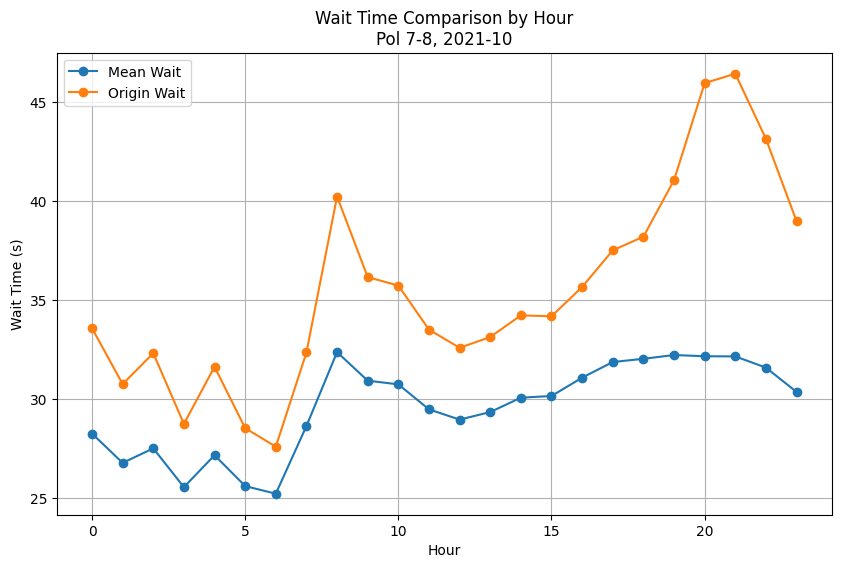

In [ ]:
#pole num 7에 대해, 2021년 10월 보행자 데이터 조합
hours = []
mean_waits = []
origin_waits = []

for hour in range(24):
    B = car_78.loc[hour]
    A = d02544fffef125e8['daily_people'].loc[24+hour]

    x_min = 36 / 3600 # 보행자가 지나는데 필요한 최소시간
    y_min = 7 / 3600 # 차량이 1대 지나는 시간
    x_max = 100 / 3600
    y_max = 300 / 3600

    x = 0
    y = 0 # y < B * x / y_min

    optimal_min = 2e9

    for i in range(36, 100):
      x = i / 3600
      for j in range(7, 300):
        y = j / 3600

        if y <= B*x*y_min: continue
        # 보행자 대기시간 기댓값
        P = (x_min + y) ** 2 / (2 * (x + y))

        # 차량 대기시간 기댓값
        l = B**2*x*y_min / (1 - B*y_min)
        C = (B*x**2 - (B*x*(B*x*-1) / (2*B)) + y_min * B*x*(B*x-1) / 2 + (B*x*l + l*(l-1)/2 - l*(l-1)/(2*B*y_min))*y_min) / (B*(x+y))

        mean = (P * A + C * B) / (A+B)
        if mean < optimal_min:
          optimal_min = mean
          people_green = i
          car_green = j
          people_wait = P
          car_wait = C


    #기존 점멸주기
    x2 = 40 / 3600
    y2 = 140 / 3600

    P = (x_min + y2) ** 2 / (2 * (x2 + y2))
    l = B**2*x2*y_min / (1 - B*y_min)
    C = (B*x2**2 - (B*x2*(B*x2*-1) / (2*B)) + y_min * B*x2*(B*x2-1) / 2 + (B*x2*l + l*(l-1)/2 - l*(l-1)/(2*B*y_min))*y_min) / (B*(x2+y2))

    origin_wait = (P * A + C * B) / (A+B)
    #origin_people_wait = P
    #origin_car_wait = C

    print(f"Hour: {hour}, People: {A}, Car: {B}, People green: {people_green}s, Car green: {car_green}s, People wait: {people_wait * 60 * 60:.3f}s, Car wait: {car_wait * 60 * 60:.3f}s, Mean wait: {optimal_min * 60 * 60:.3f}s, Origin wait: {origin_wait  * 60 * 60:.3f}s")

    # 시간대별 데이터 저장
    hours.append(hour)
    mean_waits.append(optimal_min * 60 * 60)
    origin_waits.append(origin_wait * 60 * 60)

plt.figure(figsize=(10,6))
plt.plot(hours, mean_waits, label='Mean Wait', marker='o')
plt.plot(hours, origin_waits, label='Origin Wait', marker='o')
plt.xlabel('Hour')
plt.ylabel('Wait Time (s)')
plt.title('Wait Time Comparison by Hour\nPol 7-8, 2021-10')
plt.legend()
plt.grid(True)
plt.show()

# 스마트폴 43-44번, d02544fffef125ca

In [ ]:
d02544fffef125ca = people_df[people_df['serial'] == 'd02544fffef125ca']
d02544fffef125ca = d02544fffef125ca.reset_index(drop=True)

d02544fffef125ca.head()

,serial,date,time,daily_people
0,d02544fffef125ca,2021-04-26,0,35
1,d02544fffef125ca,2021-04-26,1,11
2,d02544fffef125ca,2021-04-26,2,11
3,d02544fffef125ca,2021-04-26,3,10
4,d02544fffef125ca,2021-04-26,4,23


In [ ]:
d02544fffef125ca['date'].unique()

array(['2021-04-26', '2020-09-01', '2021-03-01'], dtype=object)

In [ ]:
pole_4344 = car_df[(car_df['pole_num'] == 43) | (car_df['pole_num'] == 44)]
pole_4344 = pole_4344.reset_index(drop=True)

pole_4344.head()

,pole_num,time,road_car
0,43,0,55
1,43,1,36
2,43,2,23
3,43,3,18
4,43,4,15


In [ ]:
car_4344 = pole_4344.groupby('time')['road_car'].sum()

# 2021년 4월

In [ ]:
def calculate_PLC(x, y, B, y_min, x_min):
    P = (x_min + y) ** 2 / (2 * (x + y))
    l = B**2*x*y_min / (1 - B*y_min)
    C = (B*x**2 - (B*x*(B*x*-1) / (2*B)) + y_min * B*x*(B*x-1) / 2 + (B*x*l + l*(l-1)/2 - l*(l-1)/(2*B*y_min))*y_min) / (B*(x+y))
    return P, l, C

#pole num 43-44에 대해, 2021년 4월 보행자 데이터 조합
hours = []
mean_waits = []
origin_waits = []
car_greens_3 = []

for hour in range(24):
    B = car_4344.loc[hour]
    A = d02544fffef125ca['daily_people'].loc[hour]

    x_min = 27 / 3600 # 보행자가 지나는데 필요한 최소시간
    y_min = 7 / 3600 # 차량이 1대 지나는 시간
    x_max = 100 / 3600
    y_max = 300 / 3600

    x = 0
    y = 0 # y < B * x / y_min

    optimal_min = 2e9

    for i in range(27, 100):
      x = i / 3600
      for j in range(7, 300):
        y = j / 3600

        if y <= B*x*y_min: continue
        P, L, C = calculate_PLC(x, y, B, y_min, x_min)
        mean = (P * A + C * B) / (A+B)
        if mean < optimal_min:
          optimal_min = mean
          people_green = i
          car_green = j
          people_wait = P
          car_wait = C

    #기존 점멸주기
    x2 = 37 / 3600
    y2 = 100 / 3600

    P = (x_min + y2) ** 2 / (2 * (x2 + y2))
    l = B**2*x2*y_min / (1 - B*y_min)
    C = (B*x2**2 - (B*x2*(B*x2*-1) / (2*B)) + y_min * B*x2*(B*x2-1) / 2 + (B*x2*l + l*(l-1)/2 - l*(l-1)/(2*B*y_min))*y_min) / (B*(x2+y2))

    origin_wait = (P * A + C * B) / (A+B)
    #origin_people_wait = P
    #origin_car_wait = C

    print(f"Hour: {hour}, People: {A}, Car: {B}, People green: {people_green}s, Car green: {car_green}s, People wait: {people_wait * 60 * 60:.2f}s, Car wait: {car_wait * 60 * 60:.2f}s, Mean wait: {optimal_min * 60 * 60:.2f}s, Origin wait: {origin_wait  * 60 * 60:.2f}s")
    car_greens_3.append(car_green)

Hour: 0, People: 35, Car: 67, People green: 27s, Car green: 39s, People wait: 33.00s, Car wait: 17.40s, Mean wait: 22.75s, Origin wait: 30.54s
Hour: 1, People: 11, Car: 42, People green: 27s, Car green: 66s, People wait: 46.50s, Car wait: 12.11s, Mean wait: 19.24s, Origin wait: 24.45s
Hour: 2, People: 11, Car: 27, People green: 27s, Car green: 47s, People wait: 37.00s, Car wait: 15.05s, Mean wait: 21.40s, Origin wait: 27.89s
Hour: 3, People: 10, Car: 22, People green: 27s, Car green: 43s, People wait: 35.00s, Car wait: 15.85s, Mean wait: 21.84s, Origin wait: 28.85s
Hour: 4, People: 23, Car: 27, People green: 27s, Car green: 24s, People wait: 25.50s, Car wait: 21.84s, Mean wait: 23.52s, Origin wait: 35.32s
Hour: 5, People: 68, Car: 194, People green: 27s, Car green: 60s, People wait: 43.50s, Car wait: 15.11s, Mean wait: 22.48s, Origin wait: 28.62s
Hour: 6, People: 110, Car: 330, People green: 27s, Car green: 75s, People wait: 51.00s, Car wait: 17.12s, Mean wait: 25.59s, Origin wait: 32.

In [ ]:
car_greens_3.sort()
print(car_greens_3)
100 - np.median(car_greens_3)

[24, 24, 26, 29, 33, 39, 43, 47, 58, 60, 60, 66, 75, 86, 88, 89, 94, 100, 104, 104, 106, 109, 129, 130]


29.5

Hour: 0, People: 35, Car: 67, People green: 27s, Car green: 68s, People wait: 47.50s, Car wait: 12.09s, Mean wait: 24.24s, Origin wait: 30.54s
Hour: 1, People: 11, Car: 42, People green: 27s, Car green: 95s, People wait: 61.00s, Car wait: 9.23s, Mean wait: 19.97s, Origin wait: 24.45s
Hour: 2, People: 11, Car: 27, People green: 27s, Car green: 76s, People wait: 51.50s, Car wait: 10.81s, Mean wait: 22.59s, Origin wait: 27.89s
Hour: 3, People: 10, Car: 22, People green: 27s, Car green: 72s, People wait: 49.50s, Car wait: 11.21s, Mean wait: 23.18s, Origin wait: 28.85s
Hour: 4, People: 23, Car: 27, People green: 27s, Car green: 53s, People wait: 40.00s, Car wait: 13.92s, Mean wait: 25.92s, Origin wait: 35.32s
Hour: 5, People: 68, Car: 194, People green: 27s, Car green: 89s, People wait: 58.00s, Car wait: 11.33s, Mean wait: 23.44s, Origin wait: 28.62s
Hour: 6, People: 110, Car: 330, People green: 27s, Car green: 104s, People wait: 65.50s, Car wait: 13.33s, Mean wait: 26.37s, Origin wait: 32.

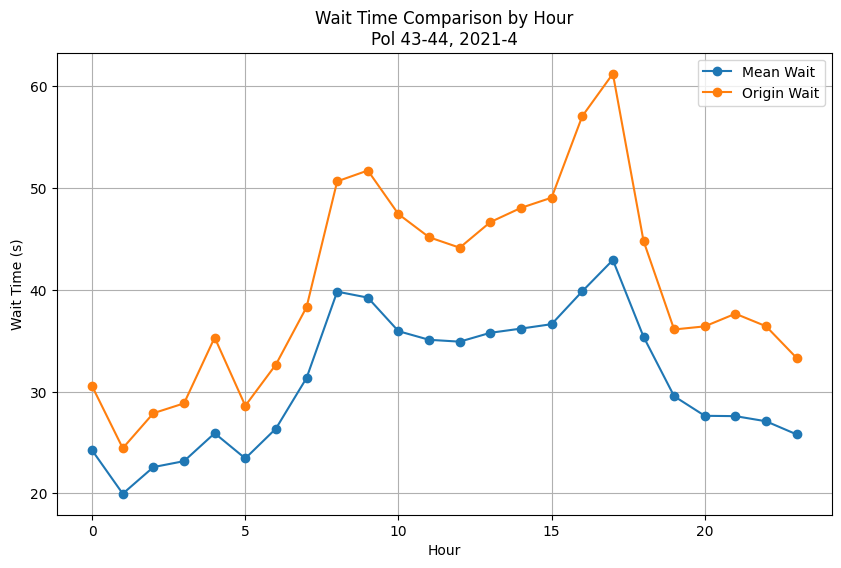

In [ ]:
hours = []
mean_waits = []
origin_waits = []

for hour in range(24):
    B = car_4344.loc[hour]
    A = d02544fffef125ca['daily_people'].loc[hour]

    x_min = 27 / 3600 # 보행자가 지나는데 필요한 최소시간
    y_min = 7 / 3600 # 차량이 1대 지나는 시간
    x_max = 100 / 3600
    y_max = 300 / 3600

    x = 0
    y = 0 # y < B * x / y_min

    optimal_min = 2e9

    for i in range(27, 100):
      x = i / 3600
      for j in range(7, 300):
        y = j / 3600

        if y <= B*x*y_min: continue
        # 보행자 대기시간 기댓값
        P = (x_min + y) ** 2 / (2 * (x + y))

        # 차량 대기시간 기댓값
        l = B**2*x*y_min / (1 - B*y_min)
        C = (B*x**2 - (B*x*(B*x*-1) / (2*B)) + y_min * B*x*(B*x-1) / 2 + (B*x*l + l*(l-1)/2 - l*(l-1)/(2*B*y_min))*y_min) / (B*(x+y))

        mean = (P * A + C * B) / (A+B)
        if mean < optimal_min:
          optimal_min = mean
          people_green = i
          car_green = j
          people_wait = P
          car_wait = C

    # 29초 더해서 다시 계산.
    car_green += 29
    x = people_green / 3600
    y = (car_green) / 3600
    P = (x_min + y) ** 2 / (2 * (x + y))

    # 차량 대기시간 기댓값
    l = B**2*x*y_min / (1 - B*y_min)
    C = (B*x**2 - (B*x*(B*x*-1) / (2*B)) + y_min * B*x*(B*x-1) / 2 + (B*x*l + l*(l-1)/2 - l*(l-1)/(2*B*y_min))*y_min) / (B*(x+y))

    people_wait = P
    car_wait = C
    optimal_min = (P * A + C * B) / (A+B)

    #기존 점멸주기
    x2 = 37 / 3600
    y2 = 100 / 3600

    P = (x_min + y2) ** 2 / (2 * (x2 + y2))
    l = B**2*x2*y_min / (1 - B*y_min)
    C = (B*x2**2 - (B*x2*(B*x2*-1) / (2*B)) + y_min * B*x2*(B*x2-1) / 2 + (B*x2*l + l*(l-1)/2 - l*(l-1)/(2*B*y_min))*y_min) / (B*(x2+y2))

    origin_wait = (P * A + C * B) / (A+B)
    #origin_people_wait = P
    #origin_car_wait = C

    print(f"Hour: {hour}, People: {A}, Car: {B}, People green: {people_green}s, Car green: {car_green}s, People wait: {people_wait * 60 * 60:.2f}s, Car wait: {car_wait * 60 * 60:.2f}s, Mean wait: {optimal_min * 60 * 60:.2f}s, Origin wait: {origin_wait  * 60 * 60:.2f}s")

    # 시간대별 데이터 저장
    hours.append(hour)
    mean_waits.append(optimal_min * 60 * 60)
    origin_waits.append(origin_wait * 60 * 60)

plt.figure(figsize=(10,6))
plt.plot(hours, mean_waits, label='Mean Wait', marker='o')
plt.plot(hours, origin_waits, label='Origin Wait', marker='o')
plt.xlabel('Hour')
plt.ylabel('Wait Time (s)')
plt.title('Wait Time Comparison by Hour\nPol 43-44, 2021-4')
plt.legend()
plt.grid(True)
plt.show()

Hour: 0, People: 35, Car: 67, People green: 27s, Car green: 39s, People wait: 33.000s, Car wait: 17.395s, Mean wait: 22.750s, Origin wait: 30.536s
Hour: 1, People: 11, Car: 42, People green: 27s, Car green: 66s, People wait: 46.500s, Car wait: 12.107s, Mean wait: 19.245s, Origin wait: 24.447s
Hour: 2, People: 11, Car: 27, People green: 27s, Car green: 47s, People wait: 37.000s, Car wait: 15.050s, Mean wait: 21.404s, Origin wait: 27.887s
Hour: 3, People: 10, Car: 22, People green: 27s, Car green: 43s, People wait: 35.000s, Car wait: 15.854s, Mean wait: 21.837s, Origin wait: 28.854s
Hour: 4, People: 23, Car: 27, People green: 27s, Car green: 24s, People wait: 25.500s, Car wait: 21.837s, Mean wait: 23.522s, Origin wait: 35.321s
Hour: 5, People: 68, Car: 194, People green: 27s, Car green: 60s, People wait: 43.500s, Car wait: 15.107s, Mean wait: 22.476s, Origin wait: 28.618s
Hour: 6, People: 110, Car: 330, People green: 27s, Car green: 75s, People wait: 51.000s, Car wait: 17.120s, Mean wait

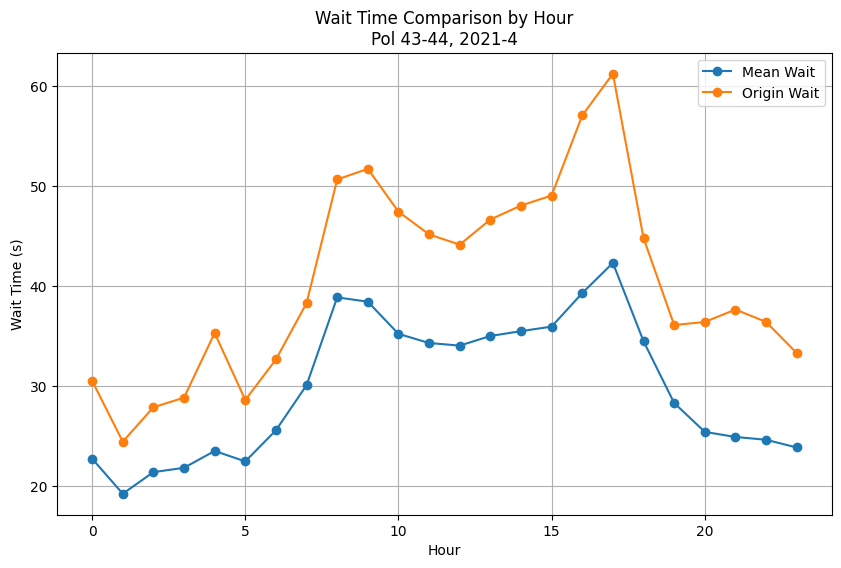

In [ ]:
#pole num 43-44에 대해, 2021년 4월 보행자 데이터 조합
hours = []
mean_waits = []
origin_waits = []

for hour in range(24):
    B = car_4344.loc[hour]
    A = d02544fffef125ca['daily_people'].loc[hour]

    x_min = 27 / 3600 # 보행자가 지나는데 필요한 최소시간
    y_min = 7 / 3600 # 차량이 1대 지나는 시간
    x_max = 100 / 3600
    y_max = 300 / 3600

    x = 0
    y = 0 # y < B * x / y_min

    optimal_min = 2e9

    for i in range(27, 100):
      x = i / 3600
      for j in range(7, 300):
        y = j / 3600

        if y <= B*x*y_min: continue
        # 보행자 대기시간 기댓값
        P = (x_min + y) ** 2 / (2 * (x + y))

        # 차량 대기시간 기댓값
        l = B**2*x*y_min / (1 - B*y_min)
        C = (B*x**2 - (B*x*(B*x*-1) / (2*B)) + y_min * B*x*(B*x-1) / 2 + (B*x*l + l*(l-1)/2 - l*(l-1)/(2*B*y_min))*y_min) / (B*(x+y))

        mean = (P * A + C * B) / (A+B)
        if mean < optimal_min:
          optimal_min = mean
          people_green = i
          car_green = j
          people_wait = P
          car_wait = C


    #기존 점멸주기
    x2 = 37 / 3600
    y2 = 100 / 3600

    P = (x_min + y2) ** 2 / (2 * (x2 + y2))
    l = B**2*x2*y_min / (1 - B*y_min)
    C = (B*x2**2 - (B*x2*(B*x2*-1) / (2*B)) + y_min * B*x2*(B*x2-1) / 2 + (B*x2*l + l*(l-1)/2 - l*(l-1)/(2*B*y_min))*y_min) / (B*(x2+y2))

    origin_wait = (P * A + C * B) / (A+B)
    #origin_people_wait = P
    #origin_car_wait = C

    print(f"Hour: {hour}, People: {A}, Car: {B}, People green: {people_green}s, Car green: {car_green}s, People wait: {people_wait * 60 * 60:.3f}s, Car wait: {car_wait * 60 * 60:.3f}s, Mean wait: {optimal_min * 60 * 60:.3f}s, Origin wait: {origin_wait  * 60 * 60:.3f}s")

    # 시간대별 데이터 저장
    hours.append(hour)
    mean_waits.append(optimal_min * 60 * 60)
    origin_waits.append(origin_wait * 60 * 60)

plt.figure(figsize=(10,6))
plt.plot(hours, mean_waits, label='Mean Wait', marker='o')
plt.plot(hours, origin_waits, label='Origin Wait', marker='o')
plt.xlabel('Hour')
plt.ylabel('Wait Time (s)')
plt.title('Wait Time Comparison by Hour\nPol 43-44, 2021-4')
plt.legend()
plt.grid(True)
plt.show()

# 2021년 9월

In [ ]:
def calculate_PLC(x, y, B, y_min, x_min):
    P = (x_min + y) ** 2 / (2 * (x + y))
    l = B**2*x*y_min / (1 - B*y_min)
    C = (B*x**2 - (B*x*(B*x*-1) / (2*B)) + y_min * B*x*(B*x-1) / 2 + (B*x*l + l*(l-1)/2 - l*(l-1)/(2*B*y_min))*y_min) / (B*(x+y))
    return P, l, C

#pole num 43-44에 대해, 2021년 9월 보행자 데이터 조합
hours = []
mean_waits = []
origin_waits = []
car_greens_4 = []

for hour in range(24):
    B = car_4344.loc[hour]
    A = d02544fffef125ca['daily_people'].loc[24+hour]

    x_min = 27 / 3600 # 보행자가 지나는데 필요한 최소시간
    y_min = 7 / 3600 # 차량이 1대 지나는 시간
    x_max = 100 / 3600
    y_max = 300 / 3600

    x = 0
    y = 0 # y < B * x / y_min

    optimal_min = 2e9

    for i in range(27, 100):
      x = i / 3600
      for j in range(7, 300):
        y = j / 3600

        if y <= B*x*y_min: continue
        P, L, C = calculate_PLC(x, y, B, y_min, x_min)
        mean = (P * A + C * B) / (A+B)
        if mean < optimal_min:
          optimal_min = mean
          people_green = i
          car_green = j
          people_wait = P
          car_wait = C

    #기존 점멸주기
    x2 = 37 / 3600
    y2 = 100 / 3600

    P = (x_min + y2) ** 2 / (2 * (x2 + y2))
    l = B**2*x2*y_min / (1 - B*y_min)
    C = (B*x2**2 - (B*x2*(B*x2*-1) / (2*B)) + y_min * B*x2*(B*x2-1) / 2 + (B*x2*l + l*(l-1)/2 - l*(l-1)/(2*B*y_min))*y_min) / (B*(x2+y2))

    origin_wait = (P * A + C * B) / (A+B)
    #origin_people_wait = P
    #origin_car_wait = C

    print(f"Hour: {hour}, People: {A}, Car: {B}, People green: {people_green}s, Car green: {car_green}s, People wait: {people_wait * 60 * 60:.2f}s, Car wait: {car_wait * 60 * 60:.2f}s, Mean wait: {optimal_min * 60 * 60:.2f}s, Origin wait: {origin_wait  * 60 * 60:.2f}s")
    car_greens_4.append(car_green)

Hour: 0, People: 46, Car: 67, People green: 27s, Car green: 31s, People wait: 29.00s, Car wait: 19.79s, Mean wait: 23.54s, Origin wait: 33.29s
Hour: 1, People: 18, Car: 42, People green: 27s, Car green: 45s, People wait: 36.00s, Car wait: 15.64s, Mean wait: 21.75s, Origin wait: 28.46s
Hour: 2, People: 19, Car: 27, People green: 27s, Car green: 29s, People wait: 28.00s, Car wait: 19.89s, Mean wait: 23.24s, Origin wait: 33.27s
Hour: 3, People: 17, Car: 22, People green: 27s, Car green: 27s, People wait: 27.00s, Car wait: 20.55s, Mean wait: 23.36s, Origin wait: 34.24s
Hour: 4, People: 31, Car: 27, People green: 27s, Car green: 17s, People wait: 22.00s, Car wait: 25.31s, Mean wait: 23.54s, Origin wait: 38.57s
Hour: 5, People: 74, Car: 194, People green: 27s, Car green: 56s, People wait: 41.50s, Car wait: 15.83s, Mean wait: 22.92s, Origin wait: 29.29s
Hour: 6, People: 117, Car: 330, People green: 27s, Car green: 72s, People wait: 49.50s, Car wait: 17.64s, Mean wait: 25.98s, Origin wait: 33.

In [ ]:
car_greens_4.sort()
print(car_greens_4)
100 - np.median(car_greens_4)

[17, 25, 26, 27, 29, 31, 32, 32, 45, 56, 63, 63, 72, 84, 88, 88, 91, 96, 98, 100, 100, 104, 125, 125]


32.5

Hour: 0, People: 46, Car: 67, People green: 27s, Car green: 63s, People wait: 45.00s, Car wait: 12.76s, Mean wait: 25.88s, Origin wait: 33.29s
Hour: 1, People: 18, Car: 42, People green: 27s, Car green: 77s, People wait: 52.00s, Car wait: 10.83s, Mean wait: 23.18s, Origin wait: 28.46s
Hour: 2, People: 19, Car: 27, People green: 27s, Car green: 61s, People wait: 44.00s, Car wait: 12.66s, Mean wait: 25.60s, Origin wait: 33.27s
Hour: 3, People: 17, Car: 22, People green: 27s, Car green: 59s, People wait: 43.00s, Car wait: 12.90s, Mean wait: 26.02s, Origin wait: 34.24s
Hour: 4, People: 31, Car: 27, People green: 27s, Car green: 49s, People wait: 38.00s, Car wait: 14.65s, Mean wait: 27.13s, Origin wait: 38.57s
Hour: 5, People: 74, Car: 194, People green: 27s, Car green: 88s, People wait: 57.50s, Car wait: 11.43s, Mean wait: 24.15s, Origin wait: 29.29s
Hour: 6, People: 117, Car: 330, People green: 27s, Car green: 104s, People wait: 65.50s, Car wait: 13.33s, Mean wait: 26.99s, Origin wait: 33

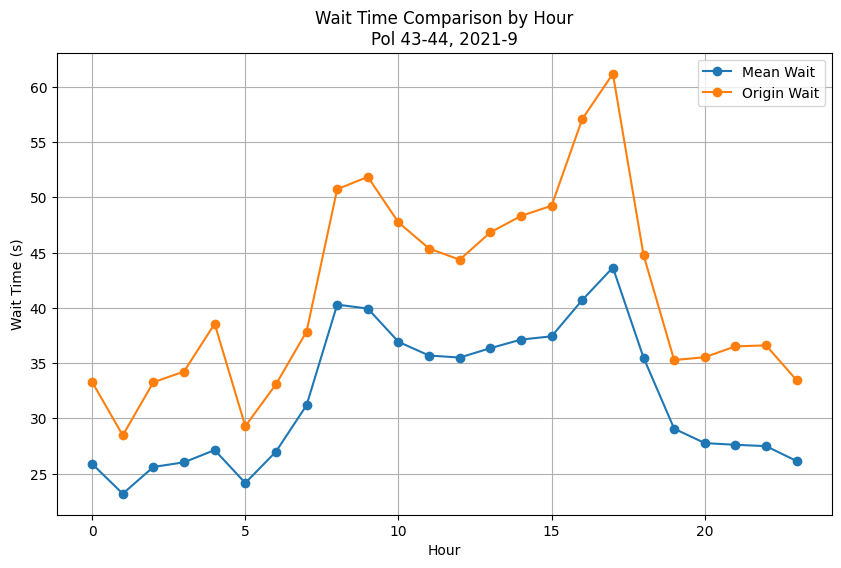

In [ ]:
hours = []
mean_waits = []
origin_waits = []

for hour in range(24):
    B = car_4344.loc[hour]
    A = d02544fffef125ca['daily_people'].loc[24+hour]

    x_min = 27 / 3600 # 보행자가 지나는데 필요한 최소시간
    y_min = 7 / 3600 # 차량이 1대 지나는 시간
    x_max = 100 / 3600
    y_max = 300 / 3600

    x = 0
    y = 0 # y < B * x / y_min

    optimal_min = 2e9

    for i in range(27, 100):
      x = i / 3600
      for j in range(7, 300):
        y = j / 3600

        if y <= B*x*y_min: continue
        # 보행자 대기시간 기댓값
        P = (x_min + y) ** 2 / (2 * (x + y))

        # 차량 대기시간 기댓값
        l = B**2*x*y_min / (1 - B*y_min)
        C = (B*x**2 - (B*x*(B*x*-1) / (2*B)) + y_min * B*x*(B*x-1) / 2 + (B*x*l + l*(l-1)/2 - l*(l-1)/(2*B*y_min))*y_min) / (B*(x+y))

        mean = (P * A + C * B) / (A+B)
        if mean < optimal_min:
          optimal_min = mean
          people_green = i
          car_green = j
          people_wait = P
          car_wait = C

    # 32초 더해서 다시 계산.
    car_green += 32
    x = people_green / 3600
    y = (car_green) / 3600
    P = (x_min + y) ** 2 / (2 * (x + y))

    # 차량 대기시간 기댓값
    l = B**2*x*y_min / (1 - B*y_min)
    C = (B*x**2 - (B*x*(B*x*-1) / (2*B)) + y_min * B*x*(B*x-1) / 2 + (B*x*l + l*(l-1)/2 - l*(l-1)/(2*B*y_min))*y_min) / (B*(x+y))

    people_wait = P
    car_wait = C
    optimal_min = (P * A + C * B) / (A+B)

    #기존 점멸주기
    x2 = 37 / 3600
    y2 = 100 / 3600

    P = (x_min + y2) ** 2 / (2 * (x2 + y2))
    l = B**2*x2*y_min / (1 - B*y_min)
    C = (B*x2**2 - (B*x2*(B*x2*-1) / (2*B)) + y_min * B*x2*(B*x2-1) / 2 + (B*x2*l + l*(l-1)/2 - l*(l-1)/(2*B*y_min))*y_min) / (B*(x2+y2))

    origin_wait = (P * A + C * B) / (A+B)
    #origin_people_wait = P
    #origin_car_wait = C

    print(f"Hour: {hour}, People: {A}, Car: {B}, People green: {people_green}s, Car green: {car_green}s, People wait: {people_wait * 60 * 60:.2f}s, Car wait: {car_wait * 60 * 60:.2f}s, Mean wait: {optimal_min * 60 * 60:.2f}s, Origin wait: {origin_wait  * 60 * 60:.2f}s")

    # 시간대별 데이터 저장
    hours.append(hour)
    mean_waits.append(optimal_min * 60 * 60)
    origin_waits.append(origin_wait * 60 * 60)

plt.figure(figsize=(10,6))
plt.plot(hours, mean_waits, label='Mean Wait', marker='o')
plt.plot(hours, origin_waits, label='Origin Wait', marker='o')
plt.xlabel('Hour')
plt.ylabel('Wait Time (s)')
plt.title('Wait Time Comparison by Hour\nPol 43-44, 2021-9')
plt.legend()
plt.grid(True)
plt.show()

Hour: 0, People: 46, Car: 67, People green: 27s, Car green: 63s, People wait: 45.00s, Car wait: 12.76s, Mean wait: 25.88s, Origin wait: 33.29s
Hour: 1, People: 18, Car: 42, People green: 27s, Car green: 77s, People wait: 52.00s, Car wait: 10.83s, Mean wait: 23.18s, Origin wait: 28.46s
Hour: 2, People: 19, Car: 27, People green: 27s, Car green: 61s, People wait: 44.00s, Car wait: 12.66s, Mean wait: 25.60s, Origin wait: 33.27s
Hour: 3, People: 17, Car: 22, People green: 27s, Car green: 59s, People wait: 43.00s, Car wait: 12.90s, Mean wait: 26.02s, Origin wait: 34.24s
Hour: 4, People: 31, Car: 27, People green: 27s, Car green: 49s, People wait: 38.00s, Car wait: 14.65s, Mean wait: 27.13s, Origin wait: 38.57s
Hour: 5, People: 74, Car: 194, People green: 27s, Car green: 88s, People wait: 57.50s, Car wait: 11.43s, Mean wait: 24.15s, Origin wait: 29.29s
Hour: 6, People: 117, Car: 330, People green: 27s, Car green: 104s, People wait: 65.50s, Car wait: 13.33s, Mean wait: 26.99s, Origin wait: 33

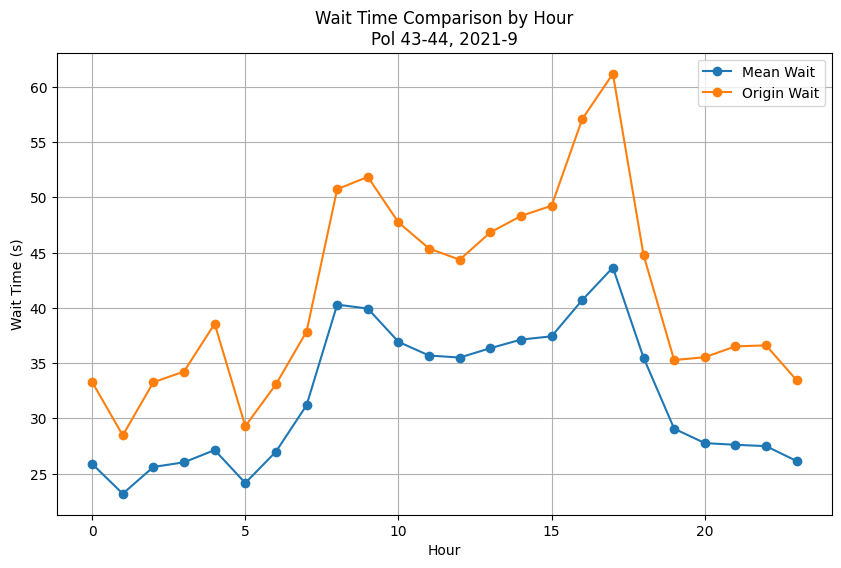

In [ ]:
hours = []
mean_waits = []
origin_waits = []

for hour in range(24):
    B = car_4344.loc[hour]
    A = d02544fffef125ca['daily_people'].loc[24+hour]

    x_min = 27 / 3600 # 보행자가 지나는데 필요한 최소시간
    y_min = 7 / 3600 # 차량이 1대 지나는 시간
    x_max = 100 / 3600
    y_max = 300 / 3600

    x = 0
    y = 0 # y < B * x / y_min

    optimal_min = 2e9

    for i in range(27, 100):
      x = i / 3600
      for j in range(7, 300):
        y = j / 3600

        if y <= B*x*y_min: continue
        # 보행자 대기시간 기댓값
        P = (x_min + y) ** 2 / (2 * (x + y))

        # 차량 대기시간 기댓값
        l = B**2*x*y_min / (1 - B*y_min)
        C = (B*x**2 - (B*x*(B*x*-1) / (2*B)) + y_min * B*x*(B*x-1) / 2 + (B*x*l + l*(l-1)/2 - l*(l-1)/(2*B*y_min))*y_min) / (B*(x+y))

        mean = (P * A + C * B) / (A+B)
        if mean < optimal_min:
          optimal_min = mean
          people_green = i
          car_green = j
          people_wait = P
          car_wait = C

    # 32초 더해서 다시 계산.
    car_green += 32
    x = people_green / 3600
    y = (car_green) / 3600
    P = (x_min + y) ** 2 / (2 * (x + y))

    # 차량 대기시간 기댓값
    l = B**2*x*y_min / (1 - B*y_min)
    C = (B*x**2 - (B*x*(B*x*-1) / (2*B)) + y_min * B*x*(B*x-1) / 2 + (B*x*l + l*(l-1)/2 - l*(l-1)/(2*B*y_min))*y_min) / (B*(x+y))

    people_wait = P
    car_wait = C
    optimal_min = (P * A + C * B) / (A+B)

    #기존 점멸주기
    x2 = 37 / 3600
    y2 = 100 / 3600

    P = (x_min + y2) ** 2 / (2 * (x2 + y2))
    l = B**2*x2*y_min / (1 - B*y_min)
    C = (B*x2**2 - (B*x2*(B*x2*-1) / (2*B)) + y_min * B*x2*(B*x2-1) / 2 + (B*x2*l + l*(l-1)/2 - l*(l-1)/(2*B*y_min))*y_min) / (B*(x2+y2))

    origin_wait = (P * A + C * B) / (A+B)
    #origin_people_wait = P
    #origin_car_wait = C

    print(f"Hour: {hour}, People: {A}, Car: {B}, People green: {people_green}s, Car green: {car_green}s, People wait: {people_wait * 60 * 60:.2f}s, Car wait: {car_wait * 60 * 60:.2f}s, Mean wait: {optimal_min * 60 * 60:.2f}s, Origin wait: {origin_wait  * 60 * 60:.2f}s")

    # 시간대별 데이터 저장
    hours.append(hour)
    mean_waits.append(optimal_min * 60 * 60)
    origin_waits.append(origin_wait * 60 * 60)

plt.figure(figsize=(10,6))
plt.plot(hours, mean_waits, label='Mean Wait', marker='o')
plt.plot(hours, origin_waits, label='Origin Wait', marker='o')
plt.xlabel('Hour')
plt.ylabel('Wait Time (s)')
plt.title('Wait Time Comparison by Hour\nPol 43-44, 2021-9')
plt.legend()
plt.grid(True)
plt.show()

# 2021년 3월

In [ ]:
def calculate_PLC(x, y, B, y_min, x_min):
    P = (x_min + y) ** 2 / (2 * (x + y))
    l = B**2*x*y_min / (1 - B*y_min)
    C = (B*x**2 - (B*x*(B*x*-1) / (2*B)) + y_min * B*x*(B*x-1) / 2 + (B*x*l + l*(l-1)/2 - l*(l-1)/(2*B*y_min))*y_min) / (B*(x+y))
    return P, l, C

#pole num 43-44에 대해, 2021년 3월 보행자 데이터 조합
hours = []
mean_waits = []
origin_waits = []
car_greens_5 = []

for hour in range(24):
    B = car_4344.loc[hour]
    A = d02544fffef125ca['daily_people'].loc[48+hour]

    x_min = 27 / 3600 # 보행자가 지나는데 필요한 최소시간
    y_min = 7 / 3600 # 차량이 1대 지나는 시간
    x_max = 100 / 3600
    y_max = 300 / 3600

    x = 0
    y = 0 # y < B * x / y_min

    optimal_min = 2e9

    for i in range(27, 100):
      x = i / 3600
      for j in range(7, 300):
        y = j / 3600

        if y <= B*x*y_min: continue
        P, L, C = calculate_PLC(x, y, B, y_min, x_min)
        mean = (P * A + C * B) / (A+B)
        if mean < optimal_min:
          optimal_min = mean
          people_green = i
          car_green = j
          people_wait = P
          car_wait = C

    #기존 점멸주기
    x2 = 37 / 3600
    y2 = 100 / 3600

    P = (x_min + y2) ** 2 / (2 * (x2 + y2))
    l = B**2*x2*y_min / (1 - B*y_min)
    C = (B*x2**2 - (B*x2*(B*x2*-1) / (2*B)) + y_min * B*x2*(B*x2-1) / 2 + (B*x2*l + l*(l-1)/2 - l*(l-1)/(2*B*y_min))*y_min) / (B*(x2+y2))

    origin_wait = (P * A + C * B) / (A+B)
    #origin_people_wait = P
    #origin_car_wait = C

    print(f"Hour: {hour}, People: {A}, Car: {B}, People green: {people_green}s, Car green: {car_green}s, People wait: {people_wait * 60 * 60:.2f}s, Car wait: {car_wait * 60 * 60:.2f}s, Mean wait: {optimal_min * 60 * 60:.2f}s, Origin wait: {origin_wait  * 60 * 60:.2f}s")
    car_greens_5.append(car_green)

Hour: 0, People: 27, Car: 67, People green: 27s, Car green: 48s, People wait: 37.50s, Car wait: 15.31s, Mean wait: 21.68s, Origin wait: 28.13s
Hour: 1, People: 10, Car: 42, People green: 27s, Car green: 70s, People wait: 48.50s, Car wait: 11.61s, Mean wait: 18.70s, Origin wait: 23.79s
Hour: 2, People: 10, Car: 27, People green: 27s, Car green: 51s, People wait: 39.00s, Car wait: 14.28s, Mean wait: 20.96s, Origin wait: 27.05s
Hour: 3, People: 11, Car: 22, People green: 27s, Car green: 40s, People wait: 33.50s, Car wait: 16.56s, Mean wait: 22.21s, Origin wait: 29.76s
Hour: 4, People: 25, Car: 27, People green: 27s, Car green: 22s, People wait: 24.50s, Car wait: 22.73s, Mean wait: 23.58s, Origin wait: 36.23s
Hour: 5, People: 69, Car: 194, People green: 27s, Car green: 59s, People wait: 43.00s, Car wait: 15.28s, Mean wait: 22.55s, Origin wait: 28.73s
Hour: 6, People: 103, Car: 330, People green: 27s, Car green: 79s, People wait: 53.00s, Car wait: 16.47s, Mean wait: 25.16s, Origin wait: 32.

In [ ]:
car_greens_5.sort()
print(car_greens_5)
100 - np.median(car_greens_5)

[22, 24, 25, 30, 37, 40, 48, 51, 57, 59, 61, 70, 79, 84, 84, 86, 93, 94, 98, 100, 100, 101, 119, 124]


25.5

Hour: 0, People: 27, Car: 67, People green: 27s, Car green: 73s, People wait: 50.00s, Car wait: 11.48s, Mean wait: 22.54s, Origin wait: 28.13s
Hour: 1, People: 10, Car: 42, People green: 27s, Car green: 95s, People wait: 61.00s, Car wait: 9.23s, Mean wait: 19.18s, Origin wait: 23.79s
Hour: 2, People: 10, Car: 27, People green: 27s, Car green: 76s, People wait: 51.50s, Car wait: 10.81s, Mean wait: 21.81s, Origin wait: 27.05s
Hour: 3, People: 11, Car: 22, People green: 27s, Car green: 65s, People wait: 46.00s, Car wait: 12.06s, Mean wait: 23.38s, Origin wait: 29.76s
Hour: 4, People: 25, Car: 27, People green: 27s, Car green: 47s, People wait: 37.00s, Car wait: 15.05s, Mean wait: 25.60s, Origin wait: 36.23s
Hour: 5, People: 69, Car: 194, People green: 27s, Car green: 84s, People wait: 55.50s, Car wait: 11.84s, Mean wait: 23.29s, Origin wait: 28.73s
Hour: 6, People: 103, Car: 330, People green: 27s, Car green: 104s, People wait: 65.50s, Car wait: 13.33s, Mean wait: 25.74s, Origin wait: 32.

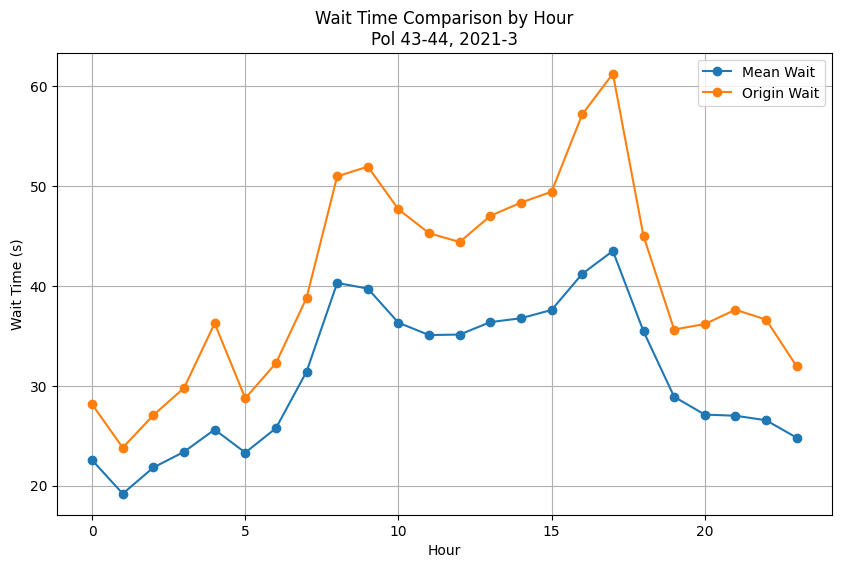

In [ ]:
hours = []
mean_waits = []
origin_waits = []

for hour in range(24):
    B = car_4344.loc[hour]
    A = d02544fffef125ca['daily_people'].loc[48+hour]

    x_min = 27 / 3600 # 보행자가 지나는데 필요한 최소시간
    y_min = 7 / 3600 # 차량이 1대 지나는 시간
    x_max = 100 / 3600
    y_max = 300 / 3600

    x = 0
    y = 0 # y < B * x / y_min

    optimal_min = 2e9

    for i in range(27, 100):
      x = i / 3600
      for j in range(7, 300):
        y = j / 3600

        if y <= B*x*y_min: continue
        # 보행자 대기시간 기댓값
        P = (x_min + y) ** 2 / (2 * (x + y))

        # 차량 대기시간 기댓값
        l = B**2*x*y_min / (1 - B*y_min)
        C = (B*x**2 - (B*x*(B*x*-1) / (2*B)) + y_min * B*x*(B*x-1) / 2 + (B*x*l + l*(l-1)/2 - l*(l-1)/(2*B*y_min))*y_min) / (B*(x+y))

        mean = (P * A + C * B) / (A+B)
        if mean < optimal_min:
          optimal_min = mean
          people_green = i
          car_green = j
          people_wait = P
          car_wait = C

    # 25초 더해서 다시 계산.
    car_green += 25
    x = people_green / 3600
    y = (car_green) / 3600
    P = (x_min + y) ** 2 / (2 * (x + y))

    # 차량 대기시간 기댓값
    l = B**2*x*y_min / (1 - B*y_min)
    C = (B*x**2 - (B*x*(B*x*-1) / (2*B)) + y_min * B*x*(B*x-1) / 2 + (B*x*l + l*(l-1)/2 - l*(l-1)/(2*B*y_min))*y_min) / (B*(x+y))

    people_wait = P
    car_wait = C
    optimal_min = (P * A + C * B) / (A+B)

    #기존 점멸주기
    x2 = 37 / 3600
    y2 = 100 / 3600

    P = (x_min + y2) ** 2 / (2 * (x2 + y2))
    l = B**2*x2*y_min / (1 - B*y_min)
    C = (B*x2**2 - (B*x2*(B*x2*-1) / (2*B)) + y_min * B*x2*(B*x2-1) / 2 + (B*x2*l + l*(l-1)/2 - l*(l-1)/(2*B*y_min))*y_min) / (B*(x2+y2))

    origin_wait = (P * A + C * B) / (A+B)
    #origin_people_wait = P
    #origin_car_wait = C

    print(f"Hour: {hour}, People: {A}, Car: {B}, People green: {people_green}s, Car green: {car_green}s, People wait: {people_wait * 60 * 60:.2f}s, Car wait: {car_wait * 60 * 60:.2f}s, Mean wait: {optimal_min * 60 * 60:.2f}s, Origin wait: {origin_wait  * 60 * 60:.2f}s")

    # 시간대별 데이터 저장
    hours.append(hour)
    mean_waits.append(optimal_min * 60 * 60)
    origin_waits.append(origin_wait * 60 * 60)

plt.figure(figsize=(10,6))
plt.plot(hours, mean_waits, label='Mean Wait', marker='o')
plt.plot(hours, origin_waits, label='Origin Wait', marker='o')
plt.xlabel('Hour')
plt.ylabel('Wait Time (s)')
plt.title('Wait Time Comparison by Hour\nPol 43-44, 2021-3')
plt.legend()
plt.grid(True)
plt.show()

# 안암역 데이터 반영

In [ ]:
anam

,hour,people,car
0,8,552,NaN
1,9,280,NaN
2,10,450,NaN
3,11,1176,NaN
4,18,966,242.0
5,19,606,152.0
6,20,462,116.0


In [ ]:
car_anam=anam.iloc[[4,5,6],[0,2]]
print(car_anam)
people_anam=anam.iloc[[4,5,6],[0,1]]
print(people_anam)

   hour    car
4    18  242.0
5    19  152.0
6    20  116.0
   hour  people
4    18     966
5    19     606
6    20     462


In [ ]:
car_anam = car_anam.set_index('hour')

In [ ]:
people_anam = people_anam.set_index('hour')

In [ ]:
#스마트폴 43번, 21년 3월
hours = []
mean_waits = []
origin_waits = []

for hour in range(18,21):
    B = car_anam.loc[hour]
    A = people_anam['people'].loc[hour]

    x_min = 27 / 3600 # 보행자가 지나는데 필요한 최소시간
    y_min = 7 / 3600 # 차량이 1대 지나는 시간
    x_max = 100 / 3600
    y_max = 300 / 3600

    x = 0
    y = 0 # y < B * x / y_min

    optimal_min = 2e9

    for i in range(27, 100):
      x = i / 3600
      for j in range(7, 300):
        y = j / 3600


        # 보행자 대기시간 기댓값
        P = (x_min + y) ** 2 / (2 * (x + y))

        # 차량 대기시간 기댓값
        l = B**2*x*y_min / (1 - B*y_min)
        C = (B*x**2 - (B*x*(B*x*-1) / (2*B)) + y_min * B*x*(B*x-1) / 2 + (B*x*l + l*(l-1)/2 - l*(l-1)/(2*B*y_min))*y_min) / (B*(x+y))

        mean = (P * A + C * B) / (A+B)


        people_green = i
        car_green = j
        people_wait = P
        car_wait = C

    # 25초 더해서 다시 계산.
    car_green += 25
    x = people_green / 3600
    y = (car_green) / 3600
    P = (x_min + y) ** 2 / (2 * (x + y))

    # 차량 대기시간 기댓값
    l = B**2*x*y_min / (1 - B*y_min)
    C = (B*x**2 - (B*x*(B*x*-1) / (2*B)) + y_min * B*x*(B*x-1) / 2 + (B*x*l + l*(l-1)/2 - l*(l-1)/(2*B*y_min))*y_min) / (B*(x+y))

    people_wait = P
    car_wait = C
    optimal_min = (P * A + C * B) / (A+B)

    #기존 점멸주기
    x2 = 37 / 3600
    y2 = 100 / 3600

    P = (x_min + y2) ** 2 / (2 * (x2 + y2))
    l = B**2*x2*y_min / (1 - B*y_min)
    C = (B*x2**2 - (B*x2*(B*x2*-1) / (2*B)) + y_min * B*x2*(B*x2-1) / 2 + (B*x2*l + l*(l-1)/2 - l*(l-1)/(2*B*y_min))*y_min) / (B*(x2+y2))

    origin_wait = (P * A + C * B) / (A+B)
    #origin_people_wait = P
    #origin_car_wait = C
    print(f"Hour: {hour}, People: {str(A.item())}, Car: {str(B.item())}, People green: {people_green}s, Car green: {car_green}s, People wait: {people_wait * 60 * 60:.2f}s, Car wait: {car_wait * 60 * 60:.2f}s, Mean wait: {optimal_min * 60 * 60:.2f}s, Origin wait: {origin_wait  * 60 * 60:.2f}s")



    # 시간대별 데이터 저장
    hours.append(hour)
    mean_waits.append(optimal_min * 60 * 60)
    origin_waits.append(origin_wait * 60 * 60)

plt.figure(figsize=(10,6))
plt.plot(hours, mean_waits, label='Mean Wait', marker='o')
plt.plot(hours, origin_waits, label='Origin Wait', marker='o')
plt.xlabel('Hour')
plt.ylabel('Wait Time (s)')
plt.title('Wait Time Comparison by Hour\nPol 43-44, 2021-3')
plt.legend()
plt.grid(True)
plt.show()

TypeError: ignored